In [12]:
import os, pickle, sys, gin, torch, time
from importlib import reload
gin.enter_interactive_mode()
sys.path.append("/gpfs/data/geraslab/Yanqi/self-supervised-mammo")


In [6]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
import model_dino
from data import transformations 

from data import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [317]:
from data import transformations #DataAugmentationDINO

In [13]:
reload(datasets)

<module 'data.datasets' from '/gpfs/data/geraslab/Yanqi/self-supervised-mammo/data/datasets.py'>

## Data

In [3]:
datalist_dir = '/gpfs/data/geraslab/Ashen/joint_learning_project/mammo_purged_09082022.pkl'
img_dir = '/gpfs/data/geraslab/jp4989/data/2021.07.16.combined_ffdm_cropped'
segmentation_dir = '/gpfs/data/geraslab/jp4989/data/2021.07.12.cropped_segmentation/new_without_artifact'

In [4]:
with open(datalist_dir, "rb") as f:
    train_dl, val_dl, ts_dl, _ = pickle.load(f)


In [318]:
reload(datasets)
class Standardizer(object):
    def __init__(self):
        pass

    def __call__(self, img):
        img = (img - img.mean()) / np.maximum(img.std(), 10 ** (-5))
        return img

class CopyChannel(object):

    def __init__(self):
        pass

    def __call__(self, img):
        img = img.repeat([3,1,1])
        return img
    
class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0):
        self.brightness = brightness
        self.contrast = contrast
    
    def __call__(self, img):
        img = transforms.functional.adjust_contrast(img = img, contrast_factor=self.contrast)
        img = transforms.functional.adjust_brightness(img=img, brightness_factor=self.brightness)
        return img


    
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, gsize=(736,480)):

        flip_and_color_jitter = transforms.Compose([

            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-45, 45),translate=(0.1,0.1), scale=(0.7, 1.5), shear=(-25, 25)),
            transforms.ToTensor(),
            CopyChannel(),
            transforms.RandomApply(
                [ColorJitter(brightness=0.4, contrast=0.8)],
                p=0.8
            ),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(size=gsize, scale=global_crops_scale, ratio=(0.75, 1.3333),interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            Standardizer(),
            
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(size=gsize, scale=global_crops_scale, ratio=(0.75, 1.3333),interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            Standardizer(),

        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        lsize = (gsize[0]*0.8,gsize[1]*0.8)
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(size=lsize, scale=local_crops_scale, ratio=(0.75, 1.3333), interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            Standardizer(),
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [319]:
transform = DataAugmentationDINO(
    (0.5,1),
    (0.05,0.4),
    0,
    (736,480)
)

#transform = transforms.Compose([transforms.Resize((1024,1024)),transforms.ToTensor()])
#transform = transformations.compose_transform(augmentation='standard', resize=(224,224), image_format="greyscale")
dataset = datasets.ImageDataset(train_dl, img_dir, segmentation_dir,  transform)
#sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
data_loader = torch.utils.data.DataLoader(
    dataset,
    #sampler=sampler,
    batch_size=4,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
    collate_fn=datasets.collate_func_img
)

In [320]:
reload(datasets)
for batch_id, batch in enumerate(data_loader):
    #print(batch)
    break
    

In [312]:
imgs, cancer_label, metadata = batch


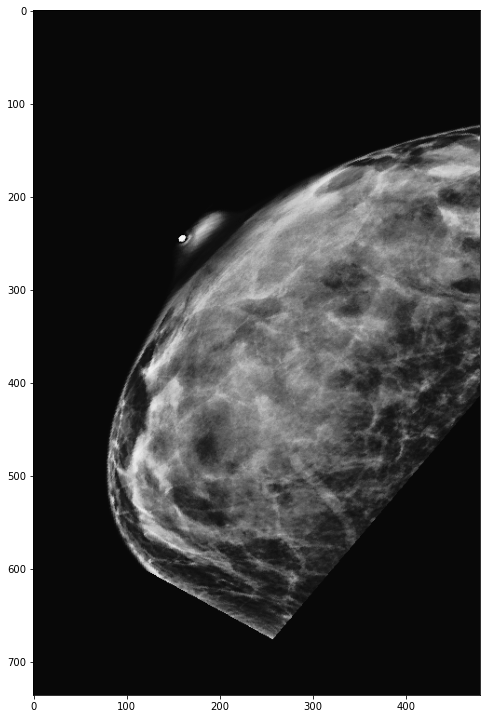

In [315]:
plt.figure(figsize=(8,16),)
plt.imshow(imgs[0][1][:1].permute(1,2,0).data.cpu().numpy(),cmap="Greys_r")

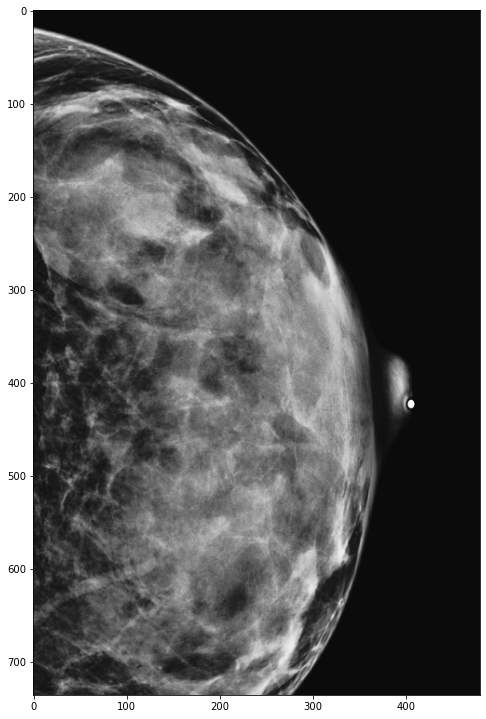

In [224]:
plt.figure(figsize=(8,16),)
plt.imshow(imgs[0][1][:1].permute(1,2,0).data.cpu().numpy(),cmap="Greys_r")

In [162]:
for idx in range(4):

    
    img1 = imgs[0][idx].permute(1,2,0).data.cpu().numpy()

    img2 = imgs[1][idx].permute(1,2,0).data.cpu().numpy()
    from matplotlib.patches import Rectangle

    plt.figure(figsize=(8,16),)
    plt.imshow(img1,cmap="Greys_r")
    ax = plt.gca()

    plt.imshow(img2, cmap="Greys_r")
    ax = plt.gca()
#     case = false_negatives[(false_negatives['PatientID'] == meta[idx]['PatientID'])&(false_negatives['View']==meta[idx]['View'])]
#     pred_boxes = case['top_boxes'].iloc[0][1]
#     mal_pred_cls = case['top_logits'].iloc[0][:,1]
#     topk = 10
#     top_k_pred, top_k_idx = torch.topk(mal_pred_cls, topk)
#     top_k_boxes = pred_boxes[top_k_idx, :].data.cpu().numpy()

#     for i,bpred in enumerate(top_k_boxes):
#         x0, y0, ww, hh = detr_output_to_bbox(bpred, w, h)
#         print(bpred)
#         bpred = torch.sigmoid(top_k_pred[i])
#         print(bpred)
#         if bpred > 0.16:
#             c ='purple'
#         else:
#             c = 'blue'
#         rect = Rectangle((x0,y0),ww,hh, linewidth=1,edgecolor=c,facecolor='none',alpha = 0.8)
#         ax.add_patch(rect)
#         rx, ry = rect.get_xy()
#         cx = rx + rect.get_width()/2.0
#         cy = ry + rect.get_height()/2.0
#         ax.annotate(str(i), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')


#     h,w = anna["size"]
#     for b_idx in range(len(anna["boxes"])):
#         bbox = anna["boxes"][b_idx]   
#         print(bbox)
#         c = "green" if anna["labels"][b_idx] == 0 else "red"
#         x0, y0, ww, hh = detr_output_to_bbox(bbox, w, h)
#         rect = Rectangle((x0,y0),ww,hh, linewidth=1,edgecolor=c,facecolor='none')
#         ax.add_patch(rect)

    plt.show()

RuntimeError: number of dims don't match in permute

In [135]:
batch[0][9]


tensor([[[[ 0.1780,  0.1400,  0.1458,  ..., -1.2993, -1.2993, -1.2993],
          [ 0.5157,  0.3994,  0.3655,  ..., -1.2993, -1.2993, -1.2993],
          [ 0.7146,  0.5682,  0.4751,  ..., -1.2993, -1.2993, -1.2993],
          ...,
          [-0.9488, -1.0101, -0.9570,  ..., -1.2993, -1.2993, -1.2993],
          [-0.9919, -1.0031, -0.9890,  ..., -1.2993, -1.2993, -1.2993],
          [-0.9581, -0.9657, -0.9234,  ..., -1.2993, -1.2993, -1.2993]],

         [[ 0.1780,  0.1400,  0.1458,  ..., -1.2993, -1.2993, -1.2993],
          [ 0.5157,  0.3994,  0.3655,  ..., -1.2993, -1.2993, -1.2993],
          [ 0.7146,  0.5682,  0.4751,  ..., -1.2993, -1.2993, -1.2993],
          ...,
          [-0.9488, -1.0101, -0.9570,  ..., -1.2993, -1.2993, -1.2993],
          [-0.9919, -1.0031, -0.9890,  ..., -1.2993, -1.2993, -1.2993],
          [-0.9581, -0.9657, -0.9234,  ..., -1.2993, -1.2993, -1.2993]],

         [[ 0.1780,  0.1400,  0.1458,  ..., -1.2993, -1.2993, -1.2993],
          [ 0.5157,  0.3994,  

## Model

In [9]:
from swin_transformer.build import build_model as build_swin

In [10]:
import swin_transformer.build
reload(swin_transformer.build)

<module 'swin_transformer.build' from '/gpfs/data/geraslab/Yanqi/self-supervised-mammo/swin_transformer/build.py'>

In [11]:
student = model_dino.DINOswin(name='swin-t',out_indices=[3],pretrained=True, frozen_stages=-1)
teacher = model_dino.DINOswin(name='swin-t',out_indices=[3],pretrained=True, frozen_stages=-1)
embed_dim = student.num_features

=> merge config from /gpfs/data/geraslab/Yanqi/self-supervised-mammo/swin_transformer/configs/swin_tiny_patch4_window7_224.yaml
0
1
2
3
=> loaded swin backbone successfully '/gpfs/data/geraslab/Yanqi/data/swin/swin_tiny_patch4_window7_224.pth'
=> merge config from /gpfs/data/geraslab/Yanqi/self-supervised-mammo/swin_transformer/configs/swin_tiny_patch4_window7_224.yaml
0
1
2
3
=> loaded swin backbone successfully '/gpfs/data/geraslab/Yanqi/data/swin/swin_tiny_patch4_window7_224.pth'


In [43]:
out_dim = 65536
student = utils.MultiCropWrapper(student, model_dino.DINOHead(
        embed_dim,
        out_dim,
        use_bn=False,
        norm_last_layer=True,
    ))

teacher = utils.MultiCropWrapper(
        teacher,
        model_dino.DINOHead(embed_dim, out_dim, use_bn=False),
    )

In [44]:
for param in teacher.parameters():
    param.requires_grad = False

In [13]:
image, label, meta_data = batch


In [14]:
image[0].shape

torch.Size([4, 3, 224, 224])

In [ ]:
swin = build_swin(name='swin-t',out_indices=[3],pretrained=True, frozen_stages=-1)

In [ ]:
x = swin(image[4])
x['3'].shape

In [ ]:
image[2].shape

In [45]:
reload(utils)

teacher_output = teacher(image[:2])  # only the 2 global views pass through the teacher
student_output = student(image[2:])

/gpfs/data/geraslab/Yanqi/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [52]:
teacher_output.mean()

tensor(-2.1530e-06)

In [25]:
reload(model_dino)
warmup_teacher_temp=0.04
teacher_temp=0.04
warmup_teacher_temp_epochs=0


class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)
        #print(student_out.shape)
        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)
        #print(teacher_out.shape)
        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        print(total_loss)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        #dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output))# * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)
        
dino_loss = DINOLoss(
        out_dim,
        10,  # total number of crops = 2 global crops + local_crops_number
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        100,
    )

In [26]:

loss = dino_loss(student_output, teacher_output, 0)


tensor(11.2936, grad_fn=<DivBackward0>)


In [ ]:
loss

In [ ]:
teacher_output

In [27]:
loss.backward()

In [ ]:
loss.shape

In [ ]:
full = np.array([2944,1920])

In [ ]:
full*0.25

In [32]:
for name, paremeters in teacher.parameters():
    print(parameters)

ValueError: too many values to unpack (expected 2)

In [41]:
# use computation graph to find all contributing tensors
def get_contributing_params(y, top_level=True):
    nf = y.grad_fn.next_functions if top_level else y.next_functions
    for f, _ in nf:
        try:
            yield f.variable
        except AttributeError:
            pass  # node has no tensor
        if f is not None:
            yield from get_contributing_params(f, top_level=False)
contributing_parameters = set(get_contributing_params(loss))
full_parameters = set(teacher.parameters())

In [42]:
full_parameters

{Parameter containing:
 tensor([ 0.0185, -0.0482, -0.0734,  ...,  0.0059,  0.0547, -0.0095],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0361, -0.0692,  0.0775,  ...,  0.0156, -0.0460,  0.0668],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1553, -0.0200,  0.1733, -0.1456,  0.2814,  0.9077, -0.1951,  0.2754,
         -0.0982, -0.3359, -0.3372,  0.3269,  0.3249,  0.1454,  0.1517,  0.1097,
          0.2415,  0.0420, -0.0487, -0.1692,  0.1722,  0.6119,  0.3482, -1.7043,
          0.2842,  0.0154, -0.2057,  0.0817, -0.0035, -0.0637, -0.1094,  0.4859,
         -0.5019,  0.0617, -0.2847,  0.4392,  0.5510,  0.5399,  0.1932,  0.5920,
          0.5934,  0.4640, -0.4812, -0.0571,  0.2259,  0.2930, -0.5882,  0.1994,
         -0.2184,  0.2277,  0.1290, -0.2551,  0.5914,  0.0776, -0.4060, -0.3968,
          0.1508, -0.0895, -0.0107,  0.0214,  0.2636,  0.2982,  0.4932, -0.4715,
          0.4295,  0.3090,  0.3626,  0.2981,  0.0472,  0.0502, -0.7982, -0.0366,
    